In [ ]:
%pip install azure-ai-ml
%pip install -U 'azureml-rag[faiss]>=0.1.14'

# Productionize Vector Index with Test Data Generation, Auto Prompt, Evaluations and Prompt Flow

In the other notebooks [listed here](./README.md), we have seen how to create a Vector Index from your data in AzureML. The next step is to use a Vector Index with a Large Language Model, retrieving relevant documents to augment what the model generates, while also testing multiple prompts to find the best and evaluating the performance using Prompt flow and a generated test dataset.

In this notebook, we'll walk through setting up an AzureML Pipeline which pulls a Git Repo, creates a Vector Index, automatically generates a test dataset, finds best prompt for dataset, generates a Prompt flow and uses the test dataset to perform bulk evaluation.

## Get client for AzureML Workspace

The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

Enter your Workspace details below, running this still will write a `workspace.json` file to the current folder.

In [ ]:
%%writefile workspace.json
{
    "subscription_id": "<subscription_id>",
    "resource_group": "<resource_group_name>",
    "workspace_name": "<workspace_name>"
}

`MLClient` is how you interact with AzureML

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azureml.core import Workspace

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential, path="workspace.json")
except Exception as ex:
    raise Exception(
        "Failed to create MLClient from config file. Please modify and then run the above cell with your AzureML Workspace details."
    ) from ex
    # ml_client = MLClient(
    #     credential=credential,
    #     subscription_id="",
    #     resource_group_name="",
    #     workspace_name=""
    # )

ws = Workspace(
    subscription_id=ml_client.subscription_id,
    resource_group=ml_client.resource_group_name,
    workspace_name=ml_client.workspace_name,
)
print(ml_client)

## Creating Vector Index

For simplicity we will use a public `git repository` as data source and `text-embeddings-ada-002` from Azure OpenAI for `FAISS Vector Index` creation in this notebook. Please refer to [these notebooks](./README.md) for details on other supported data sources, embedding types and vector index stores (eg. [Azure Cognitive Search](./azure_cognitive_search/acs_mlindex_with_langchain.ipynb)).


We will use the automatically created `Default_AzureOpenAI` connection, change `aoai_connection_name` to use your own.

In [ ]:
aoai_connection_name = "Default_AzureOpenAI"

### Create Workspace Connection for Azure OpenAI

In [ ]:
from azureml.rag.utils.connections import (
    get_connection_by_name_v2,
    create_connection_v2,
)

try:
    aoai_connection = get_connection_by_name_v2(ws, aoai_connection_name)
except Exception as ex:
    # Create New Connection
    # Modify the details below to match the `Endpoint` and API key of your AOAI resource, these details can be found in Azure Portal
    raise RuntimeError(
        "Have you entered your AOAI resource details below? If so, delete me!"
    )
    aoai_connection = create_connection_v2(
        workspace=ws,
        name=aoai_connection,
        category="AzureOpenAI",
        # 'Endpoint' from Azure OpenAI resource overview
        target="https://<endpoint_name>.openai.azure.com/",
        auth_type="ApiKey",
        credentials={
            # Either `Key` from the `Keys and Endpoint` tab of your Azure OpenAI resource, will be stored in your Workspace associated Azure Key Vault.
            "key": "<api-key>"
        },
        metadata={"ApiType": "azure", "ApiVersion": "2023-05-15"},
    )

aoai_connection_id = aoai_connection["id"]

Now that your Workspace has a connection to Azure OpenAI we will make sure the `text-embedding-ada-002` model has been deployed ready for inference. This cell will fail if there is not deployment for the embeddings model, [follow these instructions](https://learn.microsoft.com/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#deploy-a-model) to deploy a model with Azure OpenAI.

In [ ]:
from azureml.rag.utils.deployment import infer_deployment


def deployment_infer(model_name: str):
    try:
        return infer_deployment(aoai_connection, model_name)
    except Exception as e:
        print(
            f"Deployment name in AOAI workspace for model '{model_name}' is not found."
        )
        print(
            f"Please create a deployment for this model by following the deploy instructions on the resource page for '{aoai_connection['properties']['target']}' in Azure Portal."
        )


aoai_embedding_model_name = "text-embedding-ada-002"
aoai_completion_model_name = "gpt-35-turbo"

aoai_embedding_deployment_name = deployment_infer(aoai_embedding_model_name)
print(
    f"Deployment name in AOAI workspace for model '{aoai_embedding_model_name}' is '{aoai_embedding_deployment_name}'"
)
aoai_completion_deployment_name = deployment_infer(aoai_completion_model_name)
print(
    f"Deployment name in AOAI workspace for model '{aoai_completion_model_name}' is '{aoai_completion_deployment_name}'"
)

Finally we will combine the deployment and model information into a uri form which the AzureML embeddings components expect as input.

In [ ]:
embeddings_model_uri = f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_embedding_model_name}"
llm_completion_config = f'{{"type":"azure_open_ai","model_name":"{aoai_completion_model_name}","deployment_name":"{aoai_completion_deployment_name}","temperature":0,"max_tokens":"1500"}}'

### Setup Pipeline to process data into Index

AzureML [Pipelines](https://learn.microsoft.com/azure/machine-learning/concept-ml-pipelines?view=azureml-api-2) connect together multiple [Components](https://learn.microsoft.com/azure/machine-learning/concept-component?view=azureml-api-2). Each Component defines inputs, code that consumes the inputs and outputs produced from the code. Pipelines themselves can have inputs, and outputs produced by connecting together individual sub Components.
To process your data for embedding and indexing we will chain together multiple components each performing their own step of the workflow.

The Components are published to a [Registry](https://learn.microsoft.com/azure/machine-learning/how-to-manage-registries?view=azureml-api-2&tabs=cli), `azureml`, which should have access to by default, it can be accessed from any Workspace.
In the below cell we get the Component Definitions from the `azureml` registry.

In [ ]:
ml_registry = MLClient(credential=credential, registry_name="azureml")

# Clones git repository to output folder of pipeline, by default this will be on the default Workspace Datastore `workspaceblobstore`
git_clone_component = ml_registry.components.get("llm_rag_git_clone", label="latest")
# Walks input folder according to provided glob pattern (all files by default: '**/*') and attempts to open them, extract text chunks and further chunk if necessary to fir within provided `chunk_size`.
crack_and_chunk_component = ml_registry.components.get(
    "llm_rag_crack_and_chunk", label="latest"
)
# Reads input folder of files containing chunks and their metadata as batches, in parallel, and generates embeddings for each chunk. Output format is produced and loaded by `azureml.rag.embeddings.EmbeddingContainer`.
generate_embeddings_component = ml_registry.components.get(
    "llm_rag_generate_embeddings", label="latest"
)
# Reads input folder produced by `azureml.rag.embeddings.EmbeddingsContainer.save()` and inserts all documents (chunk, metadata, embedding_vector) int a Faiss index and in-memory document store. Writes an MLIndex yaml detailing the index and embeddings model information.
create_faiss_index_component = ml_registry.components.get(
    "llm_rag_create_faiss_index", label="latest"
)
# Takes a uri to a storage location where an MLIndex yaml is stored and registers it as an MLIndex Data asset in the AzureML Workspace.
register_mlindex_component = ml_registry.components.get(
    "llm_rag_register_mlindex_asset", label="latest"
)

# Generates test data for QA model training and evaluation
data_generation_component = ml_registry.components.get(
    "llm_rag_qa_data_generation", label="latest"
)
# Takes a uri to a storage location where test data is stored and registers it as a uri_file Data asset in the AzureML Workspace.
register_qa_data_component = ml_registry.components.get(
    "llm_rag_register_qa_data_asset", label="latest"
)

# Create a Prompt flow with given prompts, index, llm and evaluation data
promptflow_creation_component = ml_registry.components.get(
    "llm_rag_create_promptflow", label="latest"
)

Each Component has documentation which provides an overall description of the Components purpose and each of the inputs/outputs.
For example we can see understand what `data_generation_component` does by inspecting the Component definition.

In [ ]:
print(data_generation_component)

Below a Pipeline is built by defining a python function which chains together the above components inputs and outputs. Arguments to the function are inputs to the Pipeline itself and the return value is a dictionary defining the outputs of the Pipeline.

In [ ]:
from azure.ai.ml import Input, Output
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities._job.pipeline._io import PipelineInput
from typing import Optional


def use_automatic_compute(component, instance_count=1, instance_type="Standard_E8s_v3"):
    """Configure input `component` to use automatic compute with `instance_count` and `instance_type`.

    This avoids the need to provision a compute cluster to run the component.
    """
    component.set_resources(
        instance_count=instance_count,
        instance_type=instance_type,
        properties={"compute_specification": {"automatic": True}},
    )
    return component


def optional_pipeline_input_provided(input: Optional[PipelineInput]):
    """Checks if optional pipeline inputs are provided."""
    return input is not None and input._data is not None


def use_aoai_connection(component, aoai_connection_id):
    """Configure input `component` to use AOAI connection."""
    if optional_pipeline_input_provided(aoai_connection_id):
        component.environment_variables[
            "AZUREML_WORKSPACE_CONNECTION_ID_AOAI"
        ] = aoai_connection_id


def set_user_identity(component):
    component.identity = {"type": "user_identity"}


# If you have an existing compute cluster you want to use instead of automatic compute, uncomment the following line, replace `dedicated_cpu_compute` with the name of your cluster.
# Also comment out the `component.set_resources` line in `use_automatic_compute` above and the `default_compute='serverless'` line below.
# @pipeline(compute=dedicated_cpu_compute)
@pipeline(default_compute="serverless")
def git_to_faiss_with_testgen(
    git_url: str,
    branch_name: str,
    embeddings_model: str,
    asset_name: str,
    llm_completion_config: str,
    data_source_glob: str = None,
    data_source_url: str = None,
    document_path_replacement_regex: str = None,
    aoai_connection_id: str = None,
):
    """Pipeline to generate embeddings from a git repository and create a Faiss index, in parallel generate test data and evaluate prompts."""

    # Vector index creation
    git_clone = git_clone_component(git_repository=git_url, branch_name=branch_name)
    use_automatic_compute(git_clone)

    crack_and_chunk = crack_and_chunk_component(
        input_data=git_clone.outputs.output_data,
        input_glob=data_source_glob,
        chunk_size=1024,
        data_source_url=data_source_url,
        document_path_replacement_regex=document_path_replacement_regex,
    )
    use_automatic_compute(crack_and_chunk)

    generate_embeddings = generate_embeddings_component(
        chunks_source=crack_and_chunk.outputs.output_chunks,
        embeddings_model=embeddings_model,
    )
    use_automatic_compute(generate_embeddings)
    use_aoai_connection(generate_embeddings, aoai_connection_id)

    create_faiss_index = create_faiss_index_component(
        embeddings=generate_embeddings.outputs.embeddings,
    )
    use_automatic_compute(create_faiss_index)

    register_mlindex = register_mlindex_component(
        storage_uri=create_faiss_index.outputs.index, asset_name=asset_name
    )
    use_automatic_compute(register_mlindex)

    # Test Data Generation
    data_generation = data_generation_component(
        input_data=crack_and_chunk.outputs.output_chunks,
        llm_config=llm_completion_config,
        dataset_size=50,
    )
    use_automatic_compute(data_generation)
    use_aoai_connection(data_generation, aoai_connection_id)

    register_qa_data = register_qa_data_component(
        storage_uri=data_generation.outputs.output_data,
        asset_name=asset_name,
        register_output=True,
    )
    use_automatic_compute(register_qa_data)

    # Prompt flow Creation
    promptflow = promptflow_creation_component(
        mlindex_asset_id=register_mlindex.outputs.asset_id,
        mlindex_name=asset_name,
        llm_connection_name=aoai_connection_id,
        llm_config=llm_completion_config,
        embedding_connection=aoai_connection_id,
        embeddings_model=embeddings_model,
    )
    use_automatic_compute(promptflow)

    return {
        "mlindex_asset_uri": create_faiss_index.outputs.index,
        "mlindex_asset_id": register_mlindex.outputs.asset_id,
        "test_data": data_generation.outputs.output_data,
    }

The settings below show how the different git and data_source parameters can be set to processes only the AzureML documentation from the larger AzureDocs git repo, and ensure the source url for each document is processed to link to the publicly hosted URL instead of the git url.

In [ ]:
git_url = "https://github.com/MicrosoftDocs/azure-docs/"
data_source_url = "https://learn.microsoft.com/en-us/azure"
data_source_glob = "articles/machine-learning/**/*"
# This regex is used to remove the 'articles' folder from the source url put in each files metadata in the index.
document_path_replacement_regex = r'{"match_pattern": "(.*)/articles/(.*)(\\.[^.]+)$", "replacement_pattern": "\\1/\\2"}'
asset_name = "azure_docs_ml_aoai_faiss_testgen"

In [ ]:
from azure.ai.ml import Input
import json

pipeline_job = git_to_faiss_with_testgen(
    git_url=git_url,
    branch_name=None,
    data_source_glob=data_source_glob,
    data_source_url=data_source_url,
    document_path_replacement_regex=document_path_replacement_regex,
    embeddings_model=embeddings_model_uri,
    aoai_connection_id=aoai_connection_id,
    llm_completion_config=llm_completion_config,
    # Name of asset to register MLIndex under, other assets (like prompt and test data) will derive their names from this name
    asset_name=asset_name,
)

# pipeline_job.settings.force_rerun = True # Rerun each time so that git_clone isn't cached, if intent is to ingest latest data.

Finally we add some properties to `pipeline_job` which ensure the Index generation progress and final Artifact appear in the PromptFlow Vector Index UI.

In [ ]:
# These are added so that in progress index generations can be listed in UI, this tagging is done automatically by UI.
pipeline_job.properties["azureml.mlIndexAssetName"] = asset_name
pipeline_job.properties["azureml.mlIndexAssetKind"] = "faiss"
pipeline_job.properties["azureml.mlIndexAssetSource"] = "Git Repository"

### Submit Pipeline

**In case of any errors see [TROUBLESHOOT.md](../../TROUBLESHOOT.md).**

The output of each step in the pipeline can be inspected via the Workspace UI, click the link under 'Details Page' after running the below cell. 

In [ ]:
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="mlindex_with_testgen"
)
running_pipeline_job

Example Job
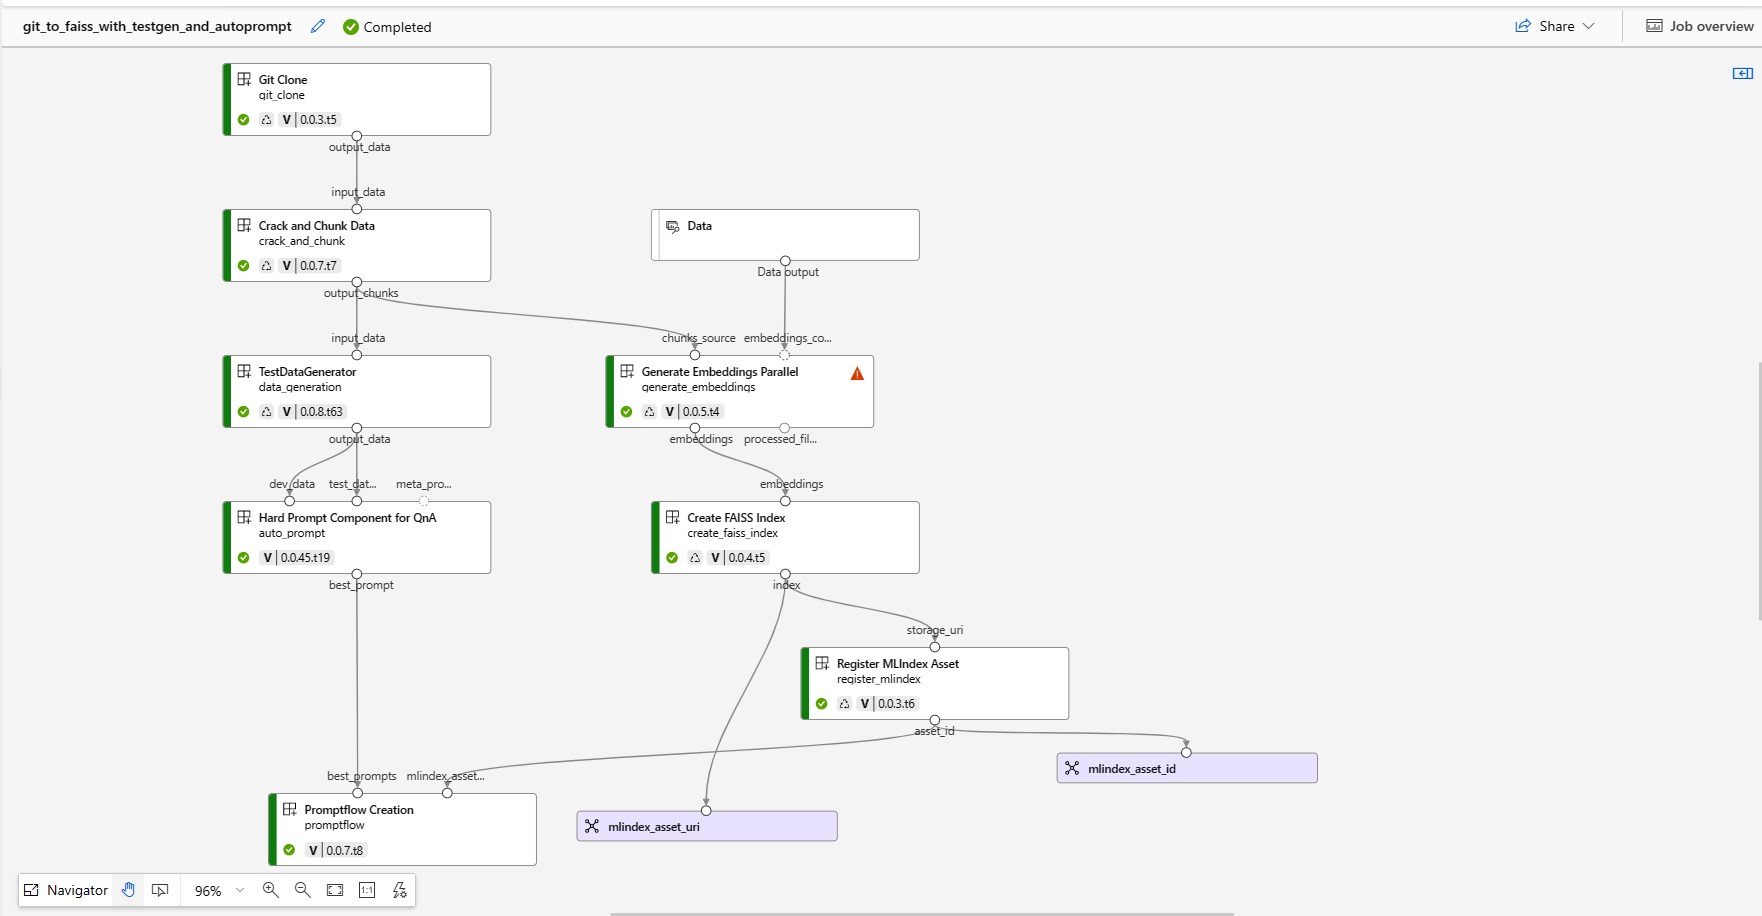


### [Optional] Review automatically generated test data

Once the pipeline job finishes, it will register autogenerated test dataset as a URI File data asset in your workspace. You can review the generated test dataset using follow code or by browsing it on the 'Explore' tab of the registered data asset.

In [ ]:
import fsspec
import pandas as pd

qa_data = ml_client.data.get(f"{asset_name}-test-data", label="latest")
with fsspec.open(qa_data.path) as f:
    df = pd.read_json(f, lines=True)
df.head(2)

## Execute as Prompt Flow

*Ensure you have enabled `Build AI solutions with Prompt flow` feature on the manage preview features pane in UI*

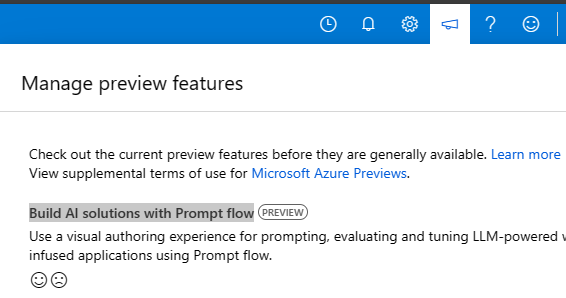

Navigate to `Prompt flow` on left navigation and switch to `Vector index` tab to access outputs from the pipeline execution above.
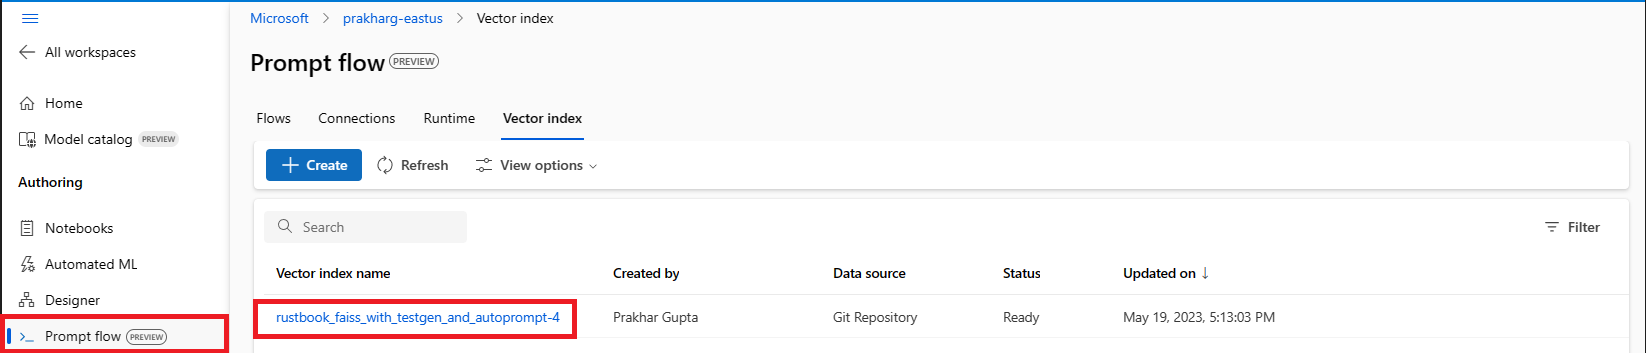

Click on `Example Promptflow` to view the generated Prompt flow for your data.
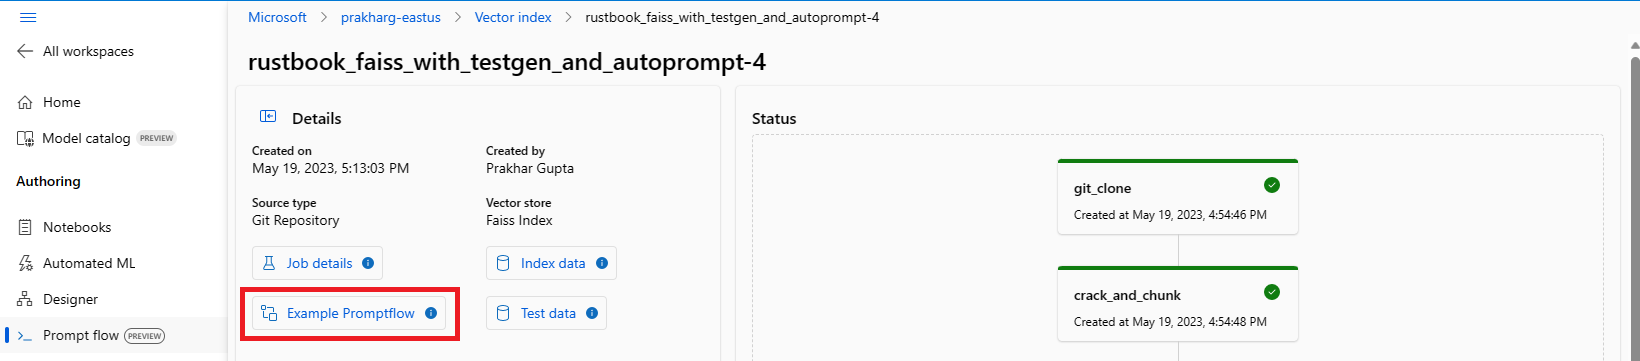

On the Prompt flow page, provide a `question` to hit `Run` to test your RAG flow. You can add Prompt Variants to the Prompt Flow as well, and use the "Generate Variants" feature to create a variation of a base prompt.
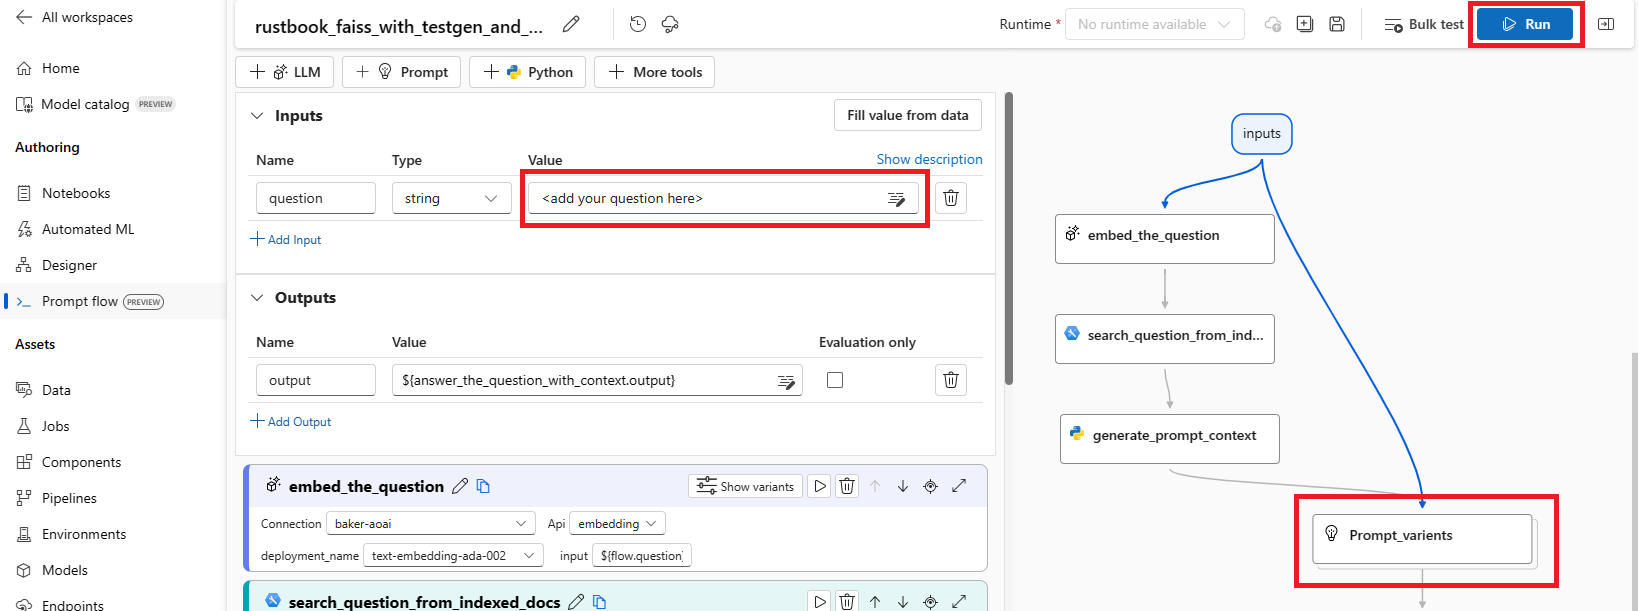

## Bulk test Prompt flow using autogenerated test data

Prompt flow provides and interactive experience to author and test RAG. Once you are satisfied with your edits you can `Save` and `Bulk test` end-to-end retrieval augmented generation using the auto-generated test dataset.

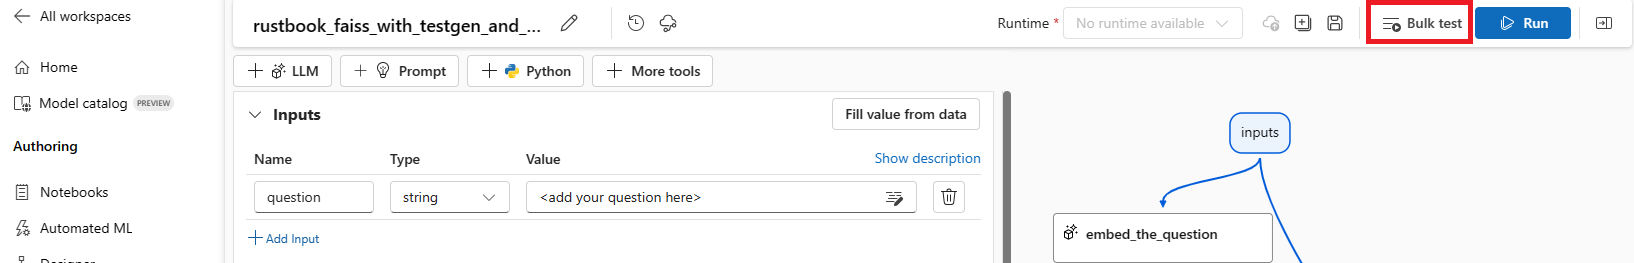

Autogeneraed test dataset registered from pipeline execution wil be listed here to select from.
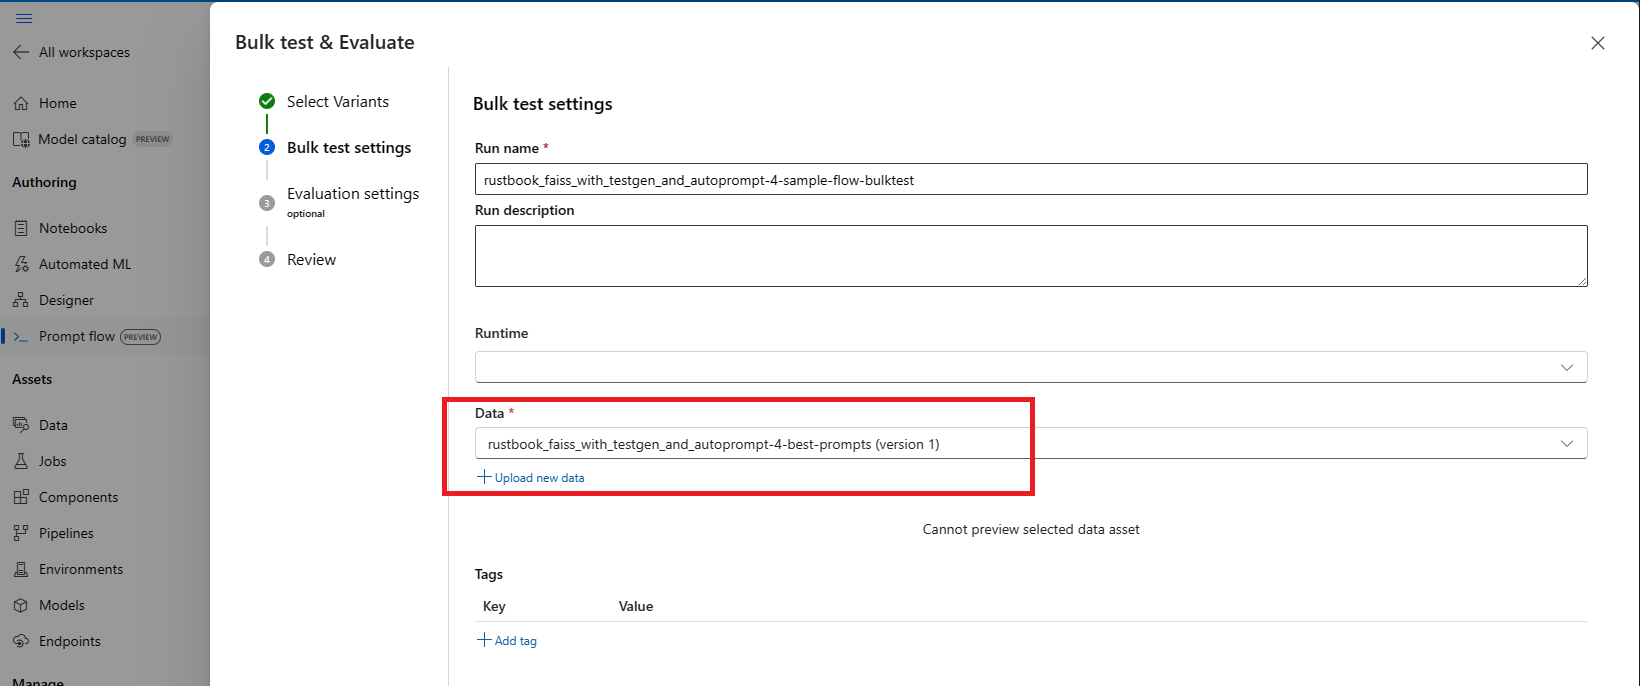

On the next sceen, you can choose from a variety of built-in evaluation method to check for groundedness, relevancy, similarity and fluency.
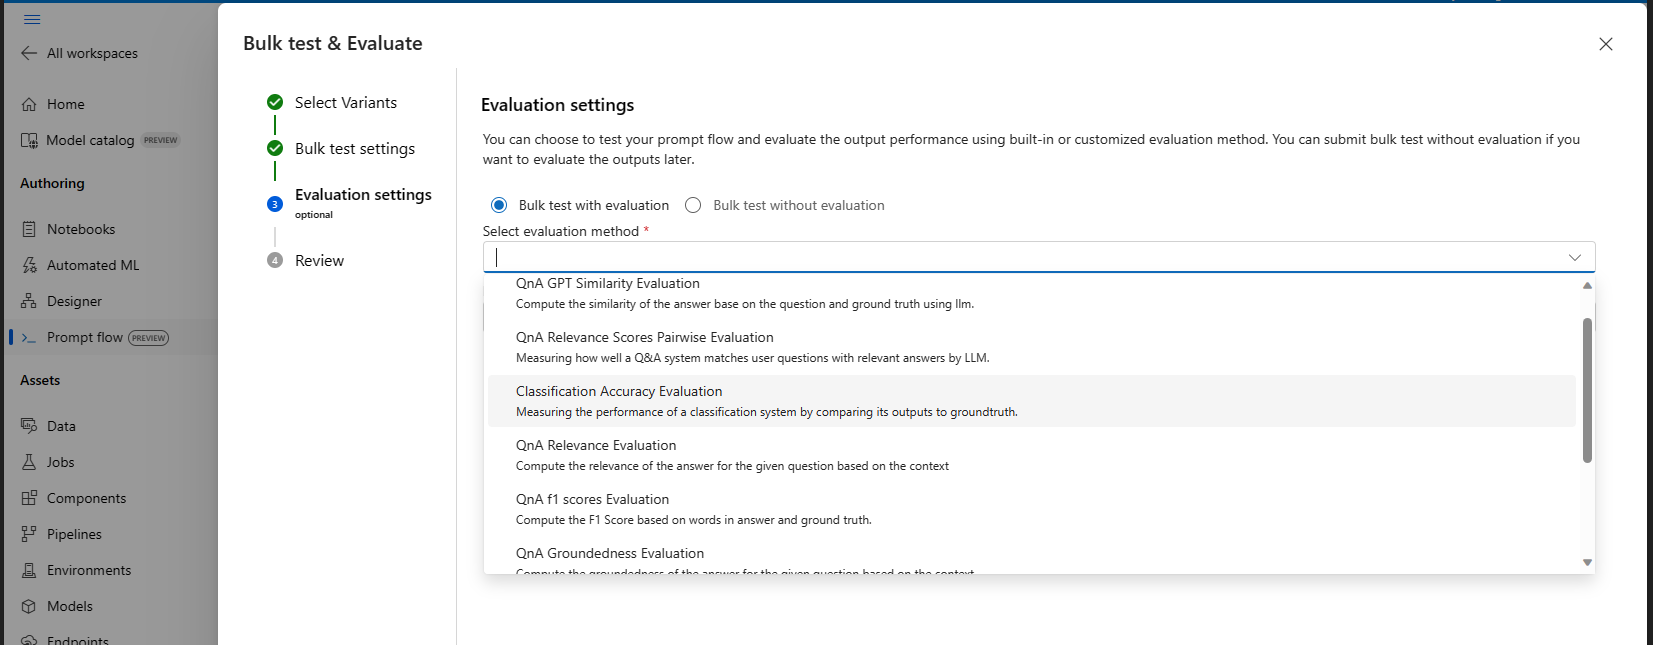

## Deploy to MIR endpoint
**TODO: link to deployment documentation**